## 1. Imports and Setup

In [ ]:
import pandas as pd
import tensorflow as tf


## 2. Data Loading

In [2]:
df = pd.read_csv('new_have_process_2370_2.csv')
df.head()

,timestamp,busy,Total Duration (hrs),Total Energy (kWh),Average Power (kW)
0,9/1/2022 12:00,23.0,1.41667,340.0,5520
1,9/1/2022 12:05,23.0,1.91667,460.0,5520
2,9/1/2022 0:10,23.0,1.91667,460.0,5520
3,9/1/2022 0:15,35.0,2.83333,680.0,8400
4,9/1/2022 0:20,39.0,3.08333,740.0,9360


## 3. Data Cleaning and Gap Analysis

In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
print(df['timestamp'])

0       2022-09-01 12:00:00
1       2022-09-01 12:05:00
2       2022-09-01 00:10:00
3       2022-09-01 00:15:00
4       2022-09-01 00:20:00
                ...        
52123   2023-02-28 23:35:00
52124   2023-02-28 23:40:00
52125   2023-02-28 23:45:00
52126   2023-02-28 23:50:00
52127   2023-02-28 23:55:00
Name: timestamp, Length: 52128, dtype: datetime64[us]


In [4]:
total_rows = len(df)
print(f'Total number of rows: {total_rows}')
time_span = df['timestamp'].max() - df['timestamp'].min()
print(f'Max timestamp: {df["timestamp"].max()}'
      f'\nMin timestamp: {df["timestamp"].min()}'
      f'\nTime span: {time_span}')

Total number of rows: 52128
Max timestamp: 2023-02-28 23:55:00
Min timestamp: 2022-09-01 00:10:00
Time span: 180 days 23:45:00


In [5]:
expected_rows = (time_span.total_seconds() / 300) + 1
print(f'Expected number of rows (5-minute data): {expected_rows}')

Expected number of rows (5-minute data): 52126.0


In [6]:
# Extract features from the timestamp
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

# Quick check: See the first few rows
df.head()

,timestamp,busy,Total Duration (hrs),Total Energy (kWh),Average Power (kW),hour,day_of_week,month
0,2022-09-01 12:00:00,23.0,1.41667,340.0,5520,12,3,9
1,2022-09-01 12:05:00,23.0,1.91667,460.0,5520,12,3,9
2,2022-09-01 00:10:00,23.0,1.91667,460.0,5520,0,3,9
3,2022-09-01 00:15:00,35.0,2.83333,680.0,8400,0,3,9
4,2022-09-01 00:20:00,39.0,3.08333,740.0,9360,0,3,9


In [7]:

df['Avg Power_lag_24h'] = df['Average Power (kW)'].shift(288)  # 288 intervals in 24 hours for 5-minute data

# Drop the first 24 rows since they will now have 'NaN' (no previous data)
df.dropna(inplace=True)

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
# Select the columns you want to use for training
features = ['hour', 'day_of_week', 'Avg Power_lag_24h', 'Average Power (kW)']
df_scaled = scaler.fit_transform(df[features])

# Convert back to a dataframe for easier handling
df_final = pd.DataFrame(df_scaled, columns=features)

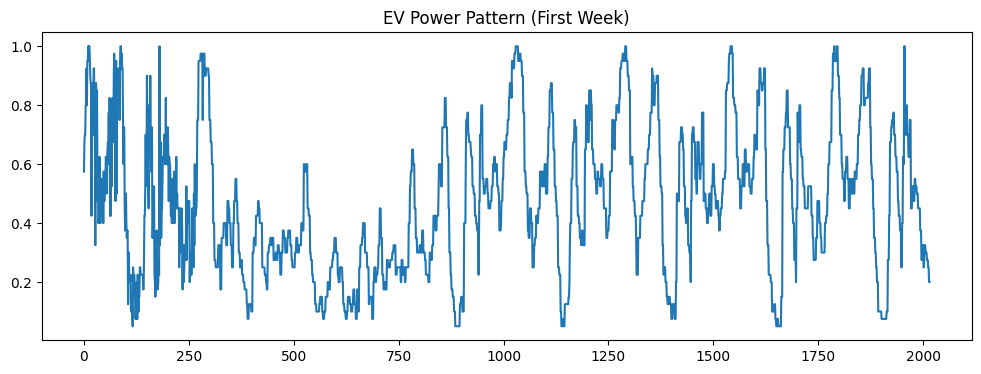

In [9]:
import matplotlib.pyplot as plt

# Plot the first week of demand data
df_final['Average Power (kW)'][:2016].plot(figsize=(12,4), title="EV Power Pattern (First Week)")
plt.show()

In [11]:
# Determine the split point
split_index = int(len(df_final) * 0.8)

train_data = df_final.iloc[:split_index]
test_data = df_final.iloc[split_index:]

print(f"Training samples: {len(train_data)}")
print(f"Testing samples: {len(test_data)}")

Training samples: 35613
Testing samples: 8904


## 4. Feature Engineering

## 5. Model Architecture

In [12]:
import numpy as np

def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length), :])
        y.append(data[i + sequence_length, -1]) # Assuming 'demand' is the last column
    return np.array(X), np.array(y)

# Let's look back at the last 24 hours to predict the next hour
SEQ_LENGTH = 288 
X_train, y_train = create_sequences(train_data.values, SEQ_LENGTH)
X_test, y_test = create_sequences(test_data.values, SEQ_LENGTH)

print(f"Shape of X_train: {X_train.shape}") # Should be (Samples, 24, Number of Features)

Shape of X_train: (35325, 288, 4)


In [ ]:
import tensorflow as tf
from tf.keras.models import Sequential
from tf.keras.layers import LSTM, Dense, Dropout

model = Sequential([
    # First LSTM layer (return_sequences=True is required to stack another LSTM)
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2), # Prevents overfitting
    
    # Second LSTM layer
    LSTM(32, activation='relu'),
    Dropout(0.2),
    
    # Final output layer (predicts 1 value: the demand)
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 288, 64)        │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 288, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,113 (117.63 KB)

 Trainable params: 30,113 (117.63 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1, # Uses 10% of training data for a quick check each epoch
    verbose=1
)

Epoch 1/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 105s 104ms/step - loss: 0.0182 - val_loss: 0.0041
Epoch 2/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 125s 126ms/step - loss: 0.0091 - val_loss: 0.0040
Epoch 3/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 138s 139ms/step - loss: 0.0072 - val_loss: 0.0027
Epoch 4/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 138s 139ms/step - loss: 0.0064 - val_loss: 0.0036
Epoch 5/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 135s 136ms/step - loss: 0.0061 - val_loss: 0.0027
Epoch 6/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 138s 139ms/step - loss: 0.0059 - val_loss: 0.0027
Epoch 7/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 139s 139ms/step - loss: 0.0057 - val_loss: 0.0024
Epoch 8/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 116s 116ms/step - loss: 0.0057 - val_loss: 0.0026
Epoch 9/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 147s 148ms/step - loss: 0.0056 - val_loss: 0.0030
Epoch 10/10
994/994 ━━━━━━━━━━━━━━━━━━━━ 17736s 18s/step - loss: 0.0055 - val_loss: 0.0027


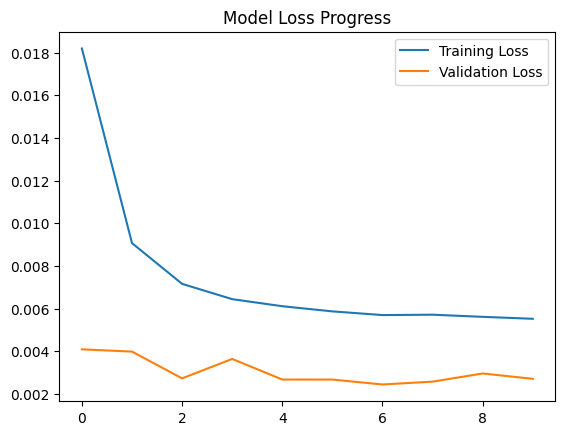

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Progress')
plt.legend()
plt.show()

## 6. Forecasting demand

In [25]:
# 1. Get the last known timestamp and features from your original dataframe
last_timestamp = df['timestamp'].iloc[-1]
current_batch = X_test[-1].reshape((1, SEQ_LENGTH, 4)) # 4 is your number of features

future_predictions = []

for i in range(24):
    # Predict the next step (scaled demand)
    current_pred = model.predict(current_batch, verbose=0)[0, 0]
    future_predictions.append(current_pred)
    
    # --- PREPARE THE NEXT ROW ---
    # We need to increment the time by one hour for each step
    next_time = last_timestamp + pd.Timedelta(hours=i+1)
    
    # Create the other 3 features (scaled as they were in training)
    # Note: Using the same logic as your manual scaling or MinMaxScaler
    next_hour = next_time.hour / 23.0  # Simple min-max scaling for hour
    next_dow = next_time.dayofweek / 6.0 # Simple min-max scaling for day
    next_lag = current_batch[0, -1, -1] # The 'demand' from the previous step becomes the new lag
    
    # Combine into a new row: [hour, day_of_week, lag, predicted_demand]
    new_row = np.array([[[next_hour, next_dow, next_lag, current_pred]]])
    
    # --- CONCATENATE ---
    # Drop the oldest step and append the new row along the time axis (axis 1)
    current_batch = np.append(current_batch[:, 1:, :], new_row, axis=1)

future_predictions = np.array(future_predictions)

## 8. Comparison

In [26]:
# 1. Grab the actual demand from the test set (first 24 hours after our starting point)
# Assuming 'demand' was the last column in your df_final
actual_scaled = test_data.iloc[:24, -1].values.reshape(-1, 1)

# 2. Use a dummy array to inverse scale the actual values
actual_dummy = np.zeros((24, len(features)))
actual_dummy[:, -1] = actual_scaled.flatten()
actual_inverse = scaler.inverse_transform(actual_dummy)[:, -1]

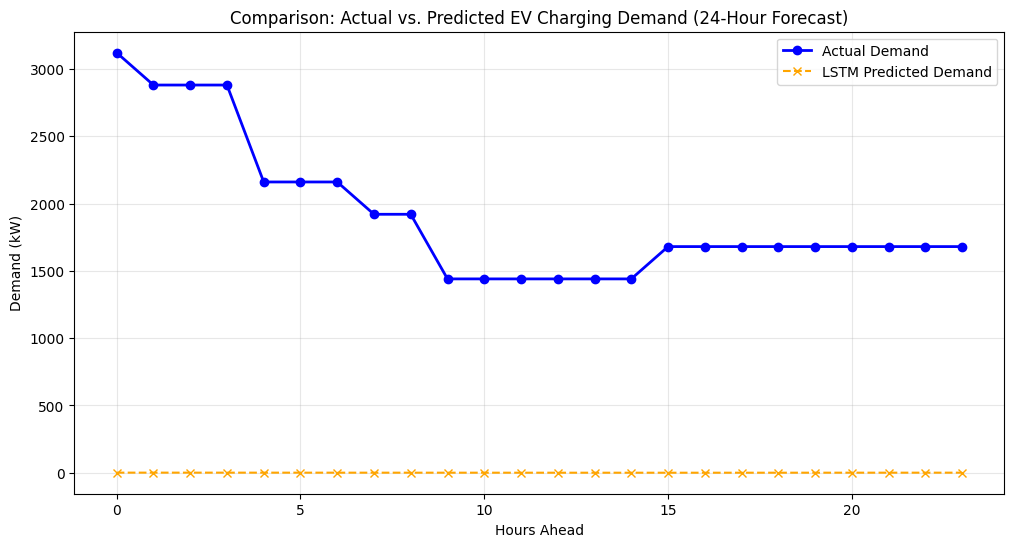

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot Actual Demand
plt.plot(actual_inverse, label='Actual Demand', color='blue', linewidth=2, marker='o')

# Plot Predicted Demand
plt.plot(future_predictions, label='LSTM Predicted Demand', color='orange', linestyle='--', marker='x')

plt.title('Comparison: Actual vs. Predicted EV Charging Demand (24-Hour Forecast)')
plt.xlabel('Hours Ahead')
plt.ylabel('Demand (kW)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [29]:
from sklearn.metrics import mean_absolute_percentage_error

mape = mean_absolute_percentage_error(actual_inverse, future_predictions)
print(f"Model Accuracy: {100 - (mape * 100):.2f}%")

Model Accuracy: 0.03%


In [30]:
import joblib

# 1. Save the Keras model (using the native .keras format)
model.save('ev_demand_lstm_model.keras')

# 2. Save the MinMaxScaler object
joblib.dump(scaler, 'ev_demand_scaler.pkl')

print("Model and Scaler saved successfully! ✅")

Model and Scaler saved successfully! ✅
